In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xcoll as xc
import xobjects as xo
import xpart as xp
from pathlib import Path
import time
start_time = time.time()

In [2]:
def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

def lin_eq_params(x1, y1, x2, y2):
    delta = x1-x2
    delta_a = y1-y2
    delta_b = x1*y2-x2*y1

    a = delta_a/delta
    b = delta_b/delta
    return a, b

def offset_colls_calc(a, b, s_rel):
    return a*s_rel + b

In [3]:
#Parameters
num_turns = 3000
num_particles = 100

nemitt_x = 3.5e-6
nemitt_y = 3.5e-6
amplitude_adt = 0.2

In [4]:
context = xo.ContextCpu()
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')

line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [5]:
tcsm = install_tcsm(line)
tidp = install_tidp(line, block_mvt=29e-3)
offset_upstream = -3.314e-3
offset_downstream = -2.152e-3

tw = line.twiss()
idx_tidvg = np.where(tw.name=='tidvg.51872')[0][0]
ap_tidvg_x = 78.6e-3/2
ap_tidvg_y = 40.8e-3/2

# sigma_tidvg_x, sigma_tidvg_y = np.sqrt(tw.betx[idx_tidvg]*nemitt_x/tw.gamma0), np.sqrt(tw.bety[idx_tidvg]*nemitt_y/tw.gamma0)
# gap_x, gap_y = ap_tidvg_x/sigma_tidvg_x, ap_tidvg_y/sigma_tidvg_y

a,b = lin_eq_params(0, offset_upstream, 4.3, offset_downstream)
jaw_RU_positions = [offset_colls_calc(a,b, 0), offset_colls_calc(a,b, 2.5), offset_colls_calc(a,b, 3.5), offset_colls_calc(a,b, 4.0)]
jaw_RD_positions = [offset_colls_calc(a,b, 2.5), offset_colls_calc(a,b, 3.5), offset_colls_calc(a,b, 4.0), offset_colls_calc(a,b, 4.3)]

tidvg_1 = xc.EverestCollimator(length=2.5, material = xc.materials.Carbon, jaw_RU = -ap_tidvg_y + jaw_RU_positions[0], jaw_RD = -ap_tidvg_y + jaw_RD_positions[0], angle = 90, side = 'right') #it is graphite but apparently that dos not exist (except Molybdenium graphite)
tidvg_2 = xc.EverestCollimator(length=1.0, material = xc.materials.Aluminium, jaw_RU = -ap_tidvg_y + jaw_RU_positions[1], jaw_RD = -ap_tidvg_y + jaw_RD_positions[1], angle = 90, side = 'right')
tidvg_3 = xc.EverestCollimator(length=0.5, material = xc.materials.Copper, jaw_RU = -ap_tidvg_y + jaw_RU_positions[2], jaw_RD = -ap_tidvg_y + jaw_RD_positions[2], angle = 90, side = 'right')
tidvg_4 = xc.EverestCollimator(length=0.3, material = xc.materials.Tungsten, jaw_RU = -ap_tidvg_y + jaw_RU_positions[3], jaw_RD = -ap_tidvg_y + jaw_RD_positions[3], angle = 90, side = 'right')

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/33012 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/33012 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


/Users/lisepauwels/Xsuite/xcoll/xcoll/beam_elements/base.py:568: RuntimeWarning: invalid value encountered in sqrt
  self._cos_yR = np.sqrt(1 - self._sin_yR**2)


In [6]:
line.discard_tracker()
center_drift = 0.35
begin_tidvg = tw.s[idx_tidvg] + center_drift
coll_names = ['tidvg.51872..1_C', 'tidvg.51872..2_Al', 'tidvg.51872..3_Cu', 'tidvg.51872..4_W']
line.collimators.install(names=coll_names, elements=[tidvg_1, tidvg_2, tidvg_3, tidvg_4], at_s=[begin_tidvg, begin_tidvg+2.5, begin_tidvg+3.5, begin_tidvg+4])
print('Before: ', tidvg_1.gap_R, tidvg_2.gap_R, tidvg_3.gap_R, tidvg_4.gap_R)

Slicing line:   0%|          | 0/33012 [00:00<?, ?it/s]

Before:  None None None None


In [7]:
adt = xc.BlowUp.install(line, name=f'adt_H_blowup', at_s=line.get_s_position('adkcv.32171'), plane='H', stop_at_turn=num_turns,
                        amplitude=amplitude_adt, use_individual_kicks=True)

line.build_tracker()
tw= line.twiss()
line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)

adt.calibrate_by_emittance(nemitt=nemitt_x, twiss=tw)

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


In [8]:
part = xp.generate_matched_gaussian_bunch(num_particles=num_particles, total_intensity_particles=2.2e11, nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=0.224, line=line) #He does not like if quadrupoles are shifted/you cannot optimise the line

*** Maximum RMS bunch length 0.2361011021355421m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004873
--> Emittance: 0.2810690751566072


In [9]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.scattering.enable()
adt.activate()
line.track(part, num_turns=num_turns, time=True, with_progress=1)
adt.deactivate()
line.scattering.disable()

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/3000 [00:00<?, ?it/s]

In [10]:
# line.discard_tracker()
# line.build_tracker(_context=xo.ContextCpu())

ThisLM = xc.LossMap(line, line_is_reversed=False, part=part, interpolation=False)
ThisLM.to_json(file=f'LM_blowup.json')

# Blowup zonder collimator

In [2]:
def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

In [2]:
context = xo.ContextCpu()
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')

line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


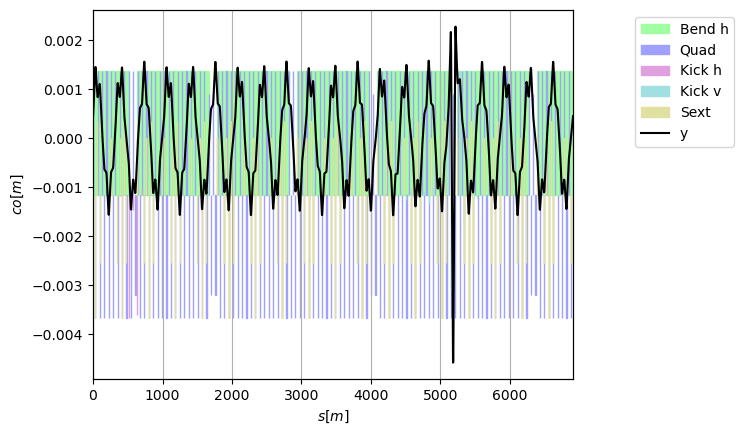

In [3]:
tw = line.twiss()
tw.plot('y')

In [4]:
plt.show()

In [5]:
#Parameters
num_turns = 3000
num_particles = 1000

nemitt_x = 3.5e-6
nemitt_y = 3.5e-6
amplitude_adt = 0.5

In [6]:
adt = xc.BlowUp.install(line, name=f'adt_H_blowup', at_s=line.get_s_position('adkcv.32171'), plane='H', stop_at_turn=num_turns,
                        amplitude=amplitude_adt, use_individual_kicks=True)

line.build_tracker()
tw= line.twiss()

adt.calibrate_by_emittance(nemitt=nemitt_x, twiss=tw)

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


In [7]:
part = xp.generate_matched_gaussian_bunch(num_particles=num_particles, total_intensity_particles=2.2e11, nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=0.224, line=line) #He does not like if quadrupoles are shifted/you cannot optimise the line

*** Maximum RMS bunch length 0.23610110213554217m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004868
--> Emittance: 0.28106907515661494


In [8]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.scattering.enable()
adt.activate()
line.track(part, num_turns=num_turns, time=True, with_progress=1)
adt.deactivate()
line.scattering.disable()

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
ThisLM = xc.LossMap(line, line_is_reversed=False, part=part, interpolation=False)

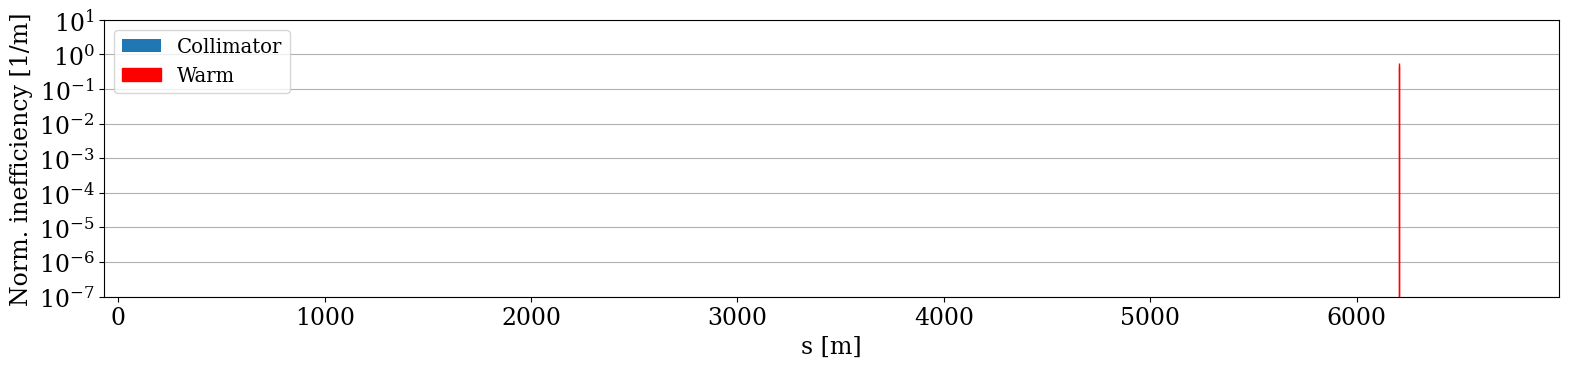

In [10]:
fig, ax =ThisLM.plot(savefig='LM_without_coll.pdf')

In [2]:
ThisLM = xc.LossMap.from_json('LM_without_coll.json')
ThisLM2 = xc.LossMap.from_json('/Users/lisepauwels/Downloads/LM_basic_off_momentum_with_coll.json')

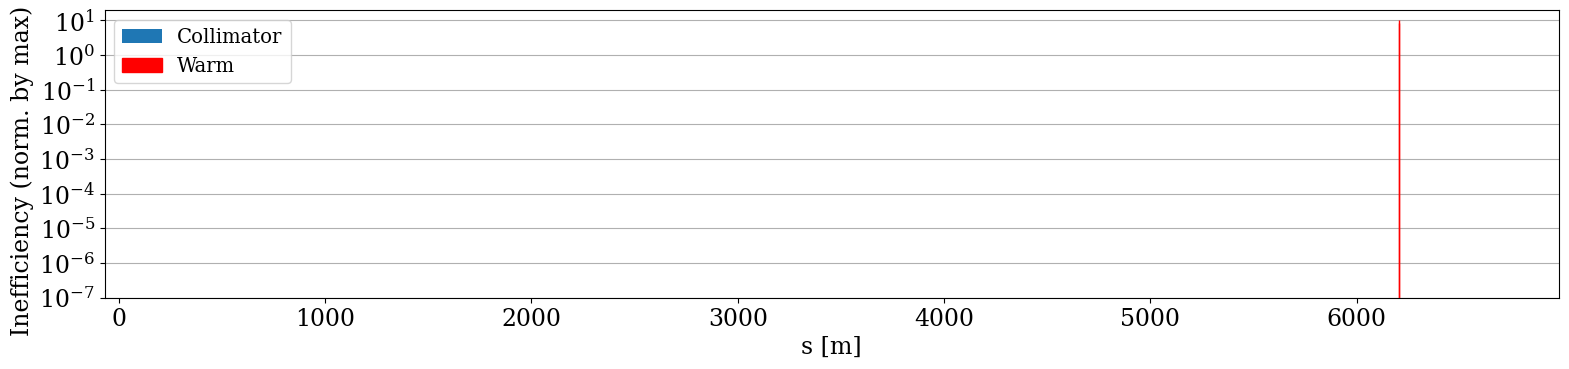

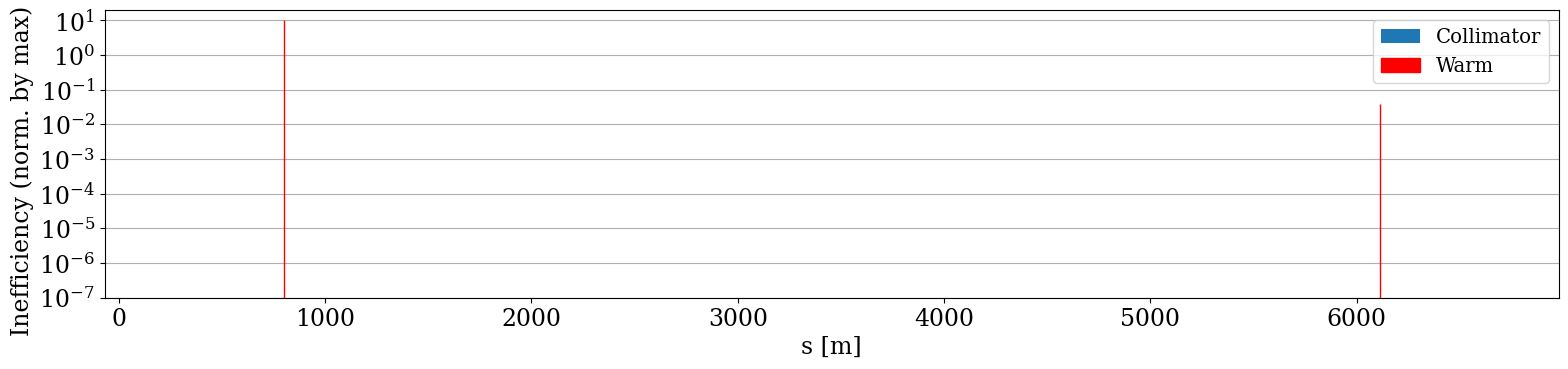

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='s [m]', ylabel='Inefficiency (norm. by max) [-]'>)

In [3]:
ThisLM.plot(savefig='LM_without_coll.pdf', norm='max')
ThisLM2.plot(savefig='LM_with_coll2.pdf', norm='max')

In [57]:
np.unique(part.at_element, return_counts=True)

(array([    0, 29723, 29739]), array([176, 372, 452]))

In [58]:
np.unique(part.state, return_counts=True)

(array([0, 1]), array([824, 176]))

In [59]:
ThisLM.to_json(file=f'LM_without_coll.json')

In [21]:
plt.savefig('LM_without_coll.pdf')

In [63]:
line.element_names[29700:29740]

('mba.61390..1',
 'mba.61390..2_aper2',
 'mba.61390..2',
 'mba.61390..3_aper2',
 'mba.61390..3',
 'mba.61390..4_aper2',
 'mba.61390..4',
 'mba.61390..5_aper2',
 'mba.61390..5',
 'mba.61390..6_aper2',
 'mba.61390..6',
 'mba.61390..7_aper2',
 'mba.61390..7',
 'mba.61390..8_aper2',
 'mba.61390..8',
 'mba.61390..9_aper2',
 'mba.61390..9',
 'mba.61390..10_aper2',
 'mba.61390..exit_map',
 'mba.61390_exit',
 'drift_1699..0',
 'veba.61390.b_aper',
 'drift_1699..1',
 'vttw.61402.a_aper',
 'drift_1699..2',
 'drift_mpsh.61402..1',
 'mpsh.61402',
 'drift_mpsh.61402..2',
 'drift_1700',
 'lsf.61405_entry',
 'lsf.61405..entry_map',
 'lsf.61405..0',
 'lsf.61405.a_aper',
 'lsf.61405..1',
 'lsf.61405.b_aper',
 'lsf.61405..2',
 'lsf.61405..exit_map',
 'lsf.61405_exit',
 'drift_1701..0',
 'vttw.61402.b_aper')

In [61]:
line.element_names[29739]

'vttw.61402.b_aper'

In [64]:
tw = line.twiss()
tw.rows['mba.61390.*']

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


TwissTable: 25 rows, 70 cols
name                             s             x            px             y            py ...
mba.61390_entry            6198.94  -3.59799e-06   9.15703e-08  -5.77372e-05   2.39169e-05
mba.61390..entry_map       6198.94  -3.59799e-06   9.15703e-08  -5.77372e-05   2.39169e-05
mba.61390..0_aper2         6198.94  -3.59799e-06   9.15499e-08  -5.77372e-05   2.39172e-05
mba.61390..0               6198.94  -3.59799e-06   9.15499e-08  -5.77372e-05   2.39172e-05
mba.61390..1_aper2         6199.57  -3.54102e-06   9.04669e-08  -4.27649e-05   2.39172e-05
mba.61390..1               6199.57  -3.54102e-06   9.04669e-08  -4.27649e-05   2.39172e-05
mba.61390..2_aper2         6200.19  -3.48472e-06   8.93838e-08  -2.77926e-05   2.39172e-05
mba.61390..2               6200.19  -3.48472e-06   8.93838e-08  -2.77926e-05   2.39172e-05
mba.61390..3_aper2         6200.82  -3.42911e-06   8.83007e-08  -1.28204e-05   2.39172e-05
mba.61390..3               6200.82  -3.42911e-06   8.8300

In [65]:
tw.rows['mba.61390.*'].dx

array([2.93281021, 2.93281021, 2.93281021, 2.93281021, 2.94330378,
       2.94330378, 2.95432394, 2.95432394, 2.96587068, 2.96587068,
       2.97794399, 2.97794399, 2.99054386, 2.99054386, 3.0036703 ,
       3.0036703 , 3.01732328, 3.01732328, 3.0315028 , 3.0315028 ,
       3.04620884, 3.04620884, 3.0614414 , 3.0614414 , 3.0614414 ])

In [68]:
np.min(tw.dx)

np.float64(-0.9150547436239002)

In [69]:
import apertls

In [81]:
ap_calc = apertls.ApertureCalculator(line)

In [82]:
x_ext = ap_calc.compute_x_extent()

In [80]:
tt = line.get_table()
tw = line.twiss()

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


In [90]:
mask = np.array([line[nn].__class__.__name__.startswith('Limit') for nn in tt.name[:-1]])
mask = np.concatenate((mask, [False]))
tt.s[mask]

array([3.2504000e+00, 3.2516000e+00, 3.4449907e+00, ..., 6.9111082e+03,
       6.9111344e+03, 6.9114082e+03], shape=(13338,))

In [86]:
line['sps$end']

View of Marker()

In [88]:
tt.name[-2]

'sps$end'

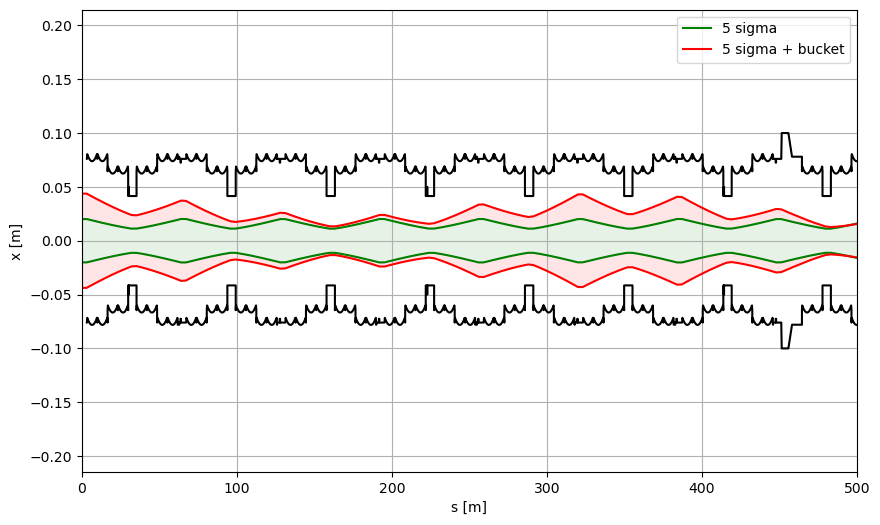

In [132]:
exn=3.5e-6
nrj=21
pmass=0.938
bucket_height=3e-3

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tt.s[mask], x_ext[:, 0], color='k')
ax.plot(tt.s[mask], x_ext[:, 1], color='k')
ax.plot(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj), color='green', label='5 sigma')
ax.plot(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj), color='green')

ax.plot(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj)+bucket_height*tw.dx, color='red', label='5 sigma + bucket')
ax.plot(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj)-bucket_height*tw.dx, color='red')

ax.fill_between(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj), 5*np.sqrt(tw.betx*exn*pmass/nrj), color='green', alpha=0.1)
ax.fill_between(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj)-bucket_height*tw.dx, -5*np.sqrt(tw.betx*exn*pmass/nrj), color='red', alpha=0.1)
ax.fill_between(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj)+bucket_height*tw.dx, 5*np.sqrt(tw.betx*exn*pmass/nrj), color='red', alpha=0.1)
ax.grid()
ax.legend()
ax.set_xlim(0,500)
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
plt.savefig('x_extent_with_bucket.pdf', dpi=300)
plt.show()

In [125]:
line2 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20.json')

Loading line from dict:   0%|          | 0/17781 [00:00<?, ?it/s]

Done loading line from dict.           


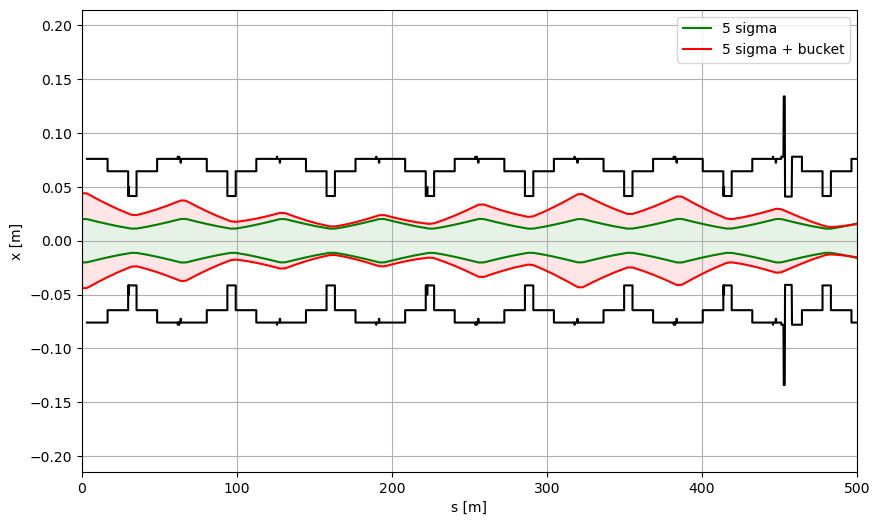

In [133]:
# aper_calc2 = apertls.ApertureCalculator(line2)
# x_ext2 = aper_calc2.compute_x_extent()
# tt2 = line2.get_table()
# tw2 = line2.twiss()

# mask2 = np.array([line2[nn].__class__.__name__.startswith('Limit') for nn in tt2.name[:-1]])
# mask2 = np.concatenate((mask2, [False]))

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tt2.s[mask2], x_ext2[:, 0], color='k')
ax.plot(tt2.s[mask2], x_ext2[:, 1], color='k')
ax.plot(tw2.s, 5*np.sqrt(tw2.betx*exn*pmass/nrj), color='green', label='5 sigma')
ax.plot(tw2.s, -5*np.sqrt(tw2.betx*exn*pmass/nrj), color='green')

ax.plot(tw2.s, 5*np.sqrt(tw2.betx*exn*pmass/nrj)+bucket_height*tw2.dx, color='red', label='5 sigma + bucket')
ax.plot(tw2.s, -5*np.sqrt(tw2.betx*exn*pmass/nrj)-bucket_height*tw2.dx, color='red')

ax.fill_between(tw2.s, -5*np.sqrt(tw2.betx*exn*pmass/nrj), 5*np.sqrt(tw2.betx*exn*pmass/nrj), color='green', alpha=0.1)
ax.fill_between(tw2.s, -5*np.sqrt(tw2.betx*exn*pmass/nrj)-bucket_height*tw2.dx, -5*np.sqrt(tw2.betx*exn*pmass/nrj), color='red', alpha=0.1)
ax.fill_between(tw2.s, 5*np.sqrt(tw2.betx*exn*pmass/nrj)+bucket_height*tw2.dx, 5*np.sqrt(tw2.betx*exn*pmass/nrj), color='red', alpha=0.1)
ax.grid()
ax.legend()
ax.set_xlim(0,500)
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
plt.savefig('x_extent_with_bucket2.pdf', dpi=300)
plt.show()

In [ ]:
line